# Grade: /100 pts
# Assignment 10: FATE Machine Learning

## Student ID: XXXXXXXX

In this coursework, we will study how to make a complex non-linear model more interpretable and we will study any fairness issues that may arise when using AI models to solve organizational problems.

Our problem will be graduate admission,  we'll create a model to predict if a person would be accepted the master program they applied for. The following questions first develop a model, then we study how to make it more interpretable, and finally, we discuss any fairness issues that arise.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve,roc_auc_score

from xgboost import XGBClassifier
import shap

/home/farhad-bat/.local/lib/python3.8/site-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/home/farhad-bat/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


For this assignment, we will use a graduate admission dataset. For further information about the data, refer to: https://www.kaggle.com/datasets/mohansacharya/graduate-admissions?resource=download&select=Admission_Predict.csv

**Variables**

1. GRE Scores ( out of 340 )
2. TOEFL Scores ( out of 120 )
3. University Rating ( out of 5 )
4. Statement of Purpose and Letter of Recommendation Strength ( out of 5 )
5. Undergraduate GPA ( out of 10 )
6. Research Experience ( either 0 or 1 )
7. Chance of Admit ( ranging from 0 to 1 )

# Part 1: Data preprocessing and model construction (20 pts)

**Task 1:** Load the data

**Task 2:** Create the target column as 1 if Change of Admit is >0.65 and 0 otherwise

**Task 3:** Drop Chance of Admit, Serial No. and University Rating

**Task 4:** Keep only rows with CGPA values between 8 and 9

**Task 5:** Save the shape in the variable df_shape and print it

**Written question:** Is this dataset imbalanced? Yes, it is highly imbalanced.

In [2]:
# read data
data_set = pd.read_csv(filepath_or_buffer='Admission_Predict.csv')

# convert target to 0 and 1
data_set['target'] = data_set['Chance of Admit '].apply(lambda val: 1 if val > 0.65 else 0).astype(int)

# drop some columns
data_set.drop(columns=['Chance of Admit ', 'Serial No.', 'University Rating'], inplace=True)

# keep only rows with CGPA values between 8 and 9
data_set = data_set[np.logical_and(data_set['CGPA'] >= 8, data_set['CGPA'] <= 9)]

# shape of dataset
df_shape = data_set.shape
print('Shape of data frame: {}'.format(df_shape))

# umber of different classes
print('Values in target:\n{}'.format(data_set['target'].value_counts()))
# umber of different classes
print('Values in target:\n{}'.format(data_set['target'].value_counts(normalize=True)))

data_set.head(10)

Shape of data frame: (277, 7)
Values in target:
1    196
0     81
Name: target, dtype: int64
Values in target:
1    0.707581
0    0.292419
Name: target, dtype: float64


,GRE Score,TOEFL Score,SOP,LOR,CGPA,Research,target
1,324,107,4.0,4.5,8.87,1,1
2,316,104,3.0,3.5,8.00,1,1
3,322,110,3.5,2.5,8.67,1,1
4,314,103,2.0,3.0,8.21,0,0
6,321,109,3.0,4.0,8.20,1,1
8,302,102,2.0,1.5,8.00,0,0
9,323,108,3.5,3.0,8.60,0,0
10,325,106,3.5,4.0,8.40,1,0
11,327,111,4.0,4.5,9.00,1,1
13,307,109,4.0,3.0,8.00,1,0


## Model Construction (30 pts)

**Task 1:** Using all features , split the dataset into training and test sets with `test_size=0.3` and `random_state=0`. (For all later settings, work with this random seed). 

**Task 2:** Construct an xgboost model with the best of the following parameters: 'n_estimators': [50,100,150,250, 300, 350], 'max_depth': [3, 4, 5], 'learning_rate' : [0.001, 0.01, 0.1]. Correctly set the argument `scale_pos_weight`. Check the documentation if needed.

Report the best parameters you found. Save them in a dictionary call best_parameters

**Task 3:** fit the model over the full data using the best parameters you found, plot the roc and report the auc score.

Fitting 3 folds for each of 54 candidates, totalling 162 fits
{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}


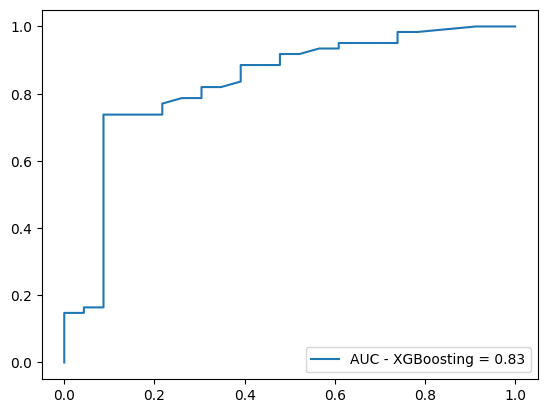

In [3]:
# all X and y
X_all = data_set.drop(columns=['target'])
y_all = data_set['target'].values

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=0)

# Define the grid search
param_grid = dict({'n_estimators'  : [50, 100, 150, 250, 300, 350],
                   'max_depth'     : [3, 4, 5],
                   'learning_rate' : [0.001, 0.01, 0.1]
                  })

# Define the crossvalidation object 
cv_object = StratifiedKFold(n_splits=3)

# Initialize the XGB model 
model = XGBClassifier(
    max_depth=3,                        # Depth of each tree
    learning_rate=0.1,                  # How much to shrink error in each subsequent training. Trade-off with no. estimators.
    n_estimators=100,                   # How many trees to use, the more the better, but decrease learning rate if many used.
    verbosity=1,                        # If to show more errors or not.
    objective='binary:logistic',        # Type of target variable.
    booster='gbtree',                   # What to boost. Trees in this case.
    n_jobs=-1,                          # Parallel jobs to run. Set your processor number. -1 for all.
    scale_pos_weight=81.0/196.0,        # Balancing of positive and negative weights.
    random_state=0,                     # Seed
    )

# Define grid search object
GridXGB = GridSearchCV(model,               # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = cv_object,      # Cross-validation object.  
                       scoring = 'roc_auc', # How to rank outputs.
                       n_jobs = -1,         # Parallel jobs. -1 is "all you have"
                       refit = True,        # If refit at the end with the best. We'll do it manually.
                       verbose = 1          # If to show what it is doing.
                      )

# Train grid search
GridXGB.fit(X_train, y_train)

# Show best params
best_parameters = GridXGB.best_params_
print(best_parameters)

# train best model with whole data
model = XGBClassifier(
    max_depth=best_parameters['max_depth'],                    # Depth of each tree
    learning_rate=best_parameters['learning_rate'],            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
    n_estimators=best_parameters['n_estimators'],              # How many trees to use, the more the better, but decrease learning rate if many used.
    verbosity=1,                                               # If to show more errors or not.
    objective='binary:logistic',                               # Type of target variable.
    booster='gbtree',                                          # What to boost. Trees in this case.
    n_jobs=-1,                                                 # Parallel jobs to run. Set your processor number. -1 for all.
    scale_pos_weight=58.0/135.0,                                # Balancing of positive and negative weights.
    random_state=0,                                            # Seed
    )
model.fit(X_train, y_train)

# prbabilities of data on test set
y_test_prob = model.predict_proba(X=X_test)
y_test_prob = y_test_prob[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = y_test, y_score = y_test_prob), decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="AUC - XGBoosting = " + str(auc))
plt.legend(loc=4)
plt.show()

# Part 2: Feature importance and Interpretability (50 pts)

## Feature Importance (11 pts)

In this part, we compare the variable importance constructed by mean-gini and mean-shap values.

**Task 1:** Plot the variable importance plot by Entropy. 

**Task 2:** Plot the variable importance plot by mean-shap value. 

**Task 3:** Discuss the differences between the variables importance and why do you think it happens. 

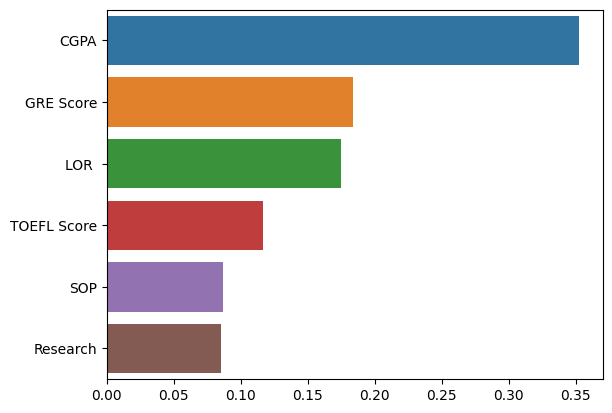

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


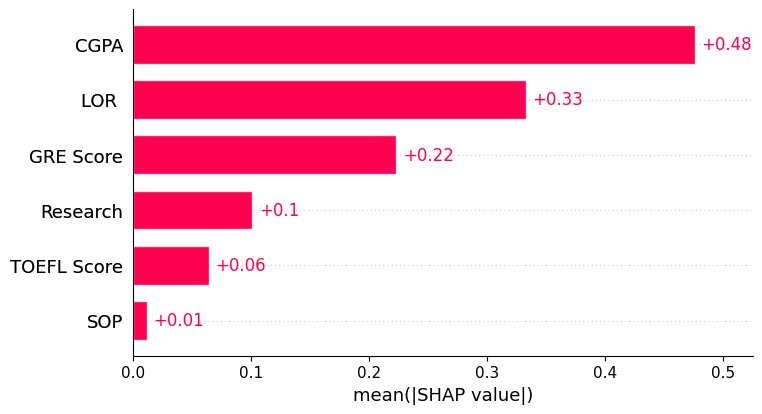

In [4]:
# feature importance obtained by gain
features_importance = model.feature_importances_

# sort
indexes = np.argsort(features_importance)[::-1]
features_importance = features_importance[indexes]

sns.barplot(x=features_importance, y=X_train.columns[indexes])
plt.show()

# feature importance by mean-shap
explainer = shap.Explainer(model=model, matplotlib=True)
train_shap_value = explainer(X_train)
shap.plots.bar(train_shap_value)
plt.show()

## Understanding and interpreting using SHAP values (39 pts)

**Task 1:** explain the model's predictions using SHAP for the first, third and fourth cases in the dataset. What can you conclude from the feature contribution plot? 

**Task 2:** Summarize the effects of all features by using a beeswarm plot. Report the first 3 features and interpret the results. 

**Task 3 :** For each of the variables "GRE Score" and "CGPA", create a Shap-value dependence scatter plot to show the effect of the single feature across the whole dataset.

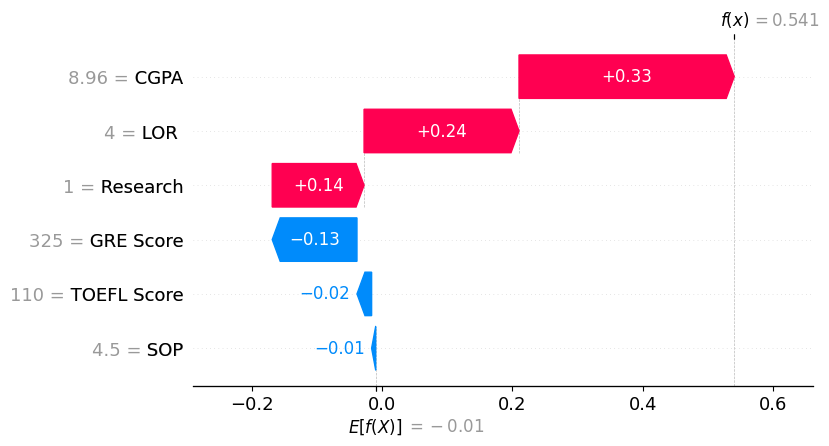

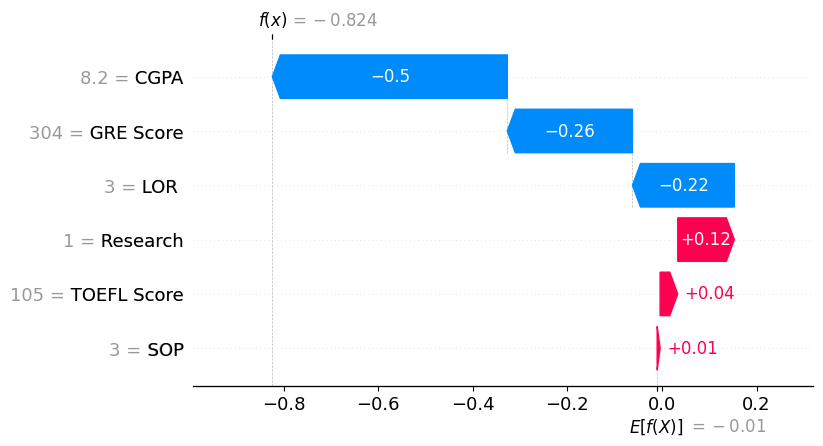

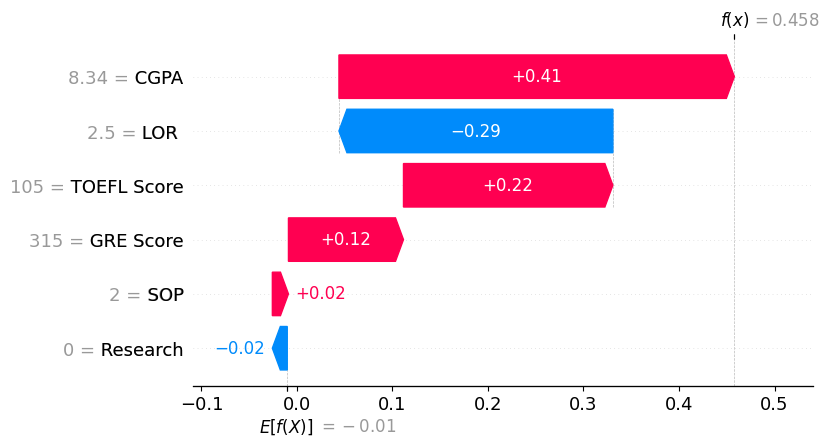

In [5]:
# for 1th, 3th, 4th
for i in [0, 2, 3]:
    shap.plots.waterfall(shap_values=train_shap_value[i])
    plt.show() 

First person has score greater than expected-value, and CGPA has the largest impact on his score. He is likely to be accepted.
Second person has very negative f(x) which is a lot smalled than expected-value (E(f(x))) and all of values are contributed negatively for him. He is unlikely to be accepted.
Third person has f(x) equal to 0.45 which is greater that E(f(x)) and he can be accepted. All values for her nearly have positive impact except LOR.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


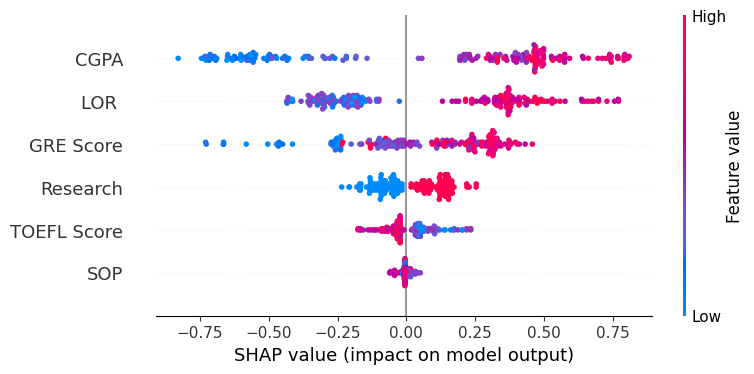

In [6]:
# beeswarm plot
shap.plots.beeswarm(shap_values=train_shap_value)

**Written Answer**: 

- CGPA presents the biggest positive contribution for bigger values of the feature. In general, people with high gpa are more likely to get accepted.

- LOR presents a discrete, non-linear behaviour that showcases the strengths of the SHAP approach. Low-medium values of the variable have a small contribution towards making the cases less likely to get accepted. Medium-high values have a slight contribution towards making cases more prone to be classified as a accepted. Very high values present the strongest contribution towards making the case more likely to be accepted.

- GRE Score has the same behavior as LOR with more cases close to 0 and the variable looks more continous.

Index(['GRE Score', 'TOEFL Score', 'SOP', 'LOR ', 'CGPA', 'Research'], dtype='object')


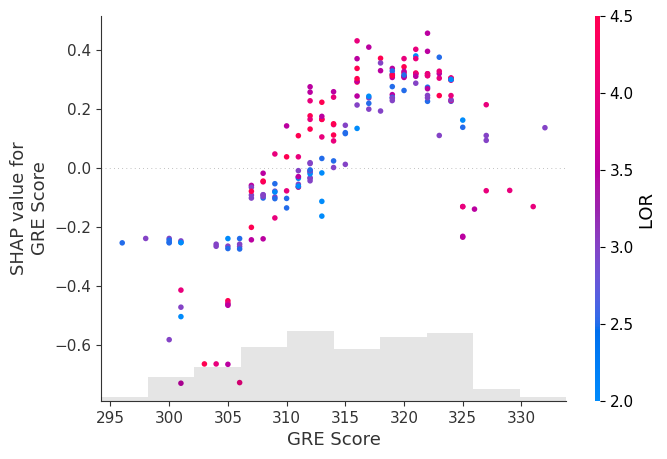

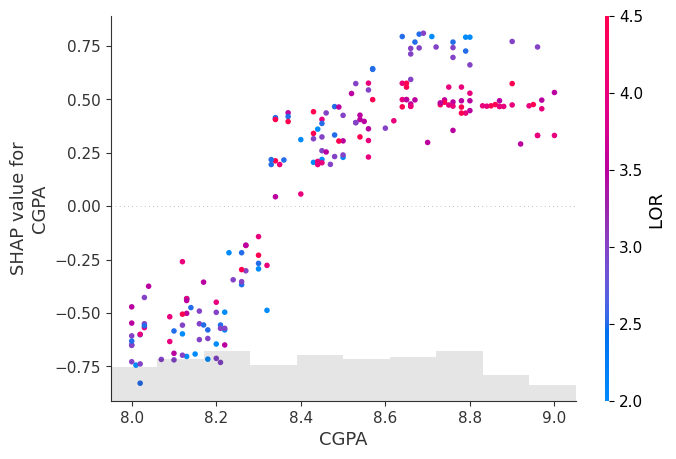

In [7]:
print(X_train.columns)

# scatter shap value for GRE Score
shap.plots.scatter(shap_values=train_shap_value[:, 0], color=train_shap_value)

# scatter shap value for CGPA Score
shap.plots.scatter(shap_values=train_shap_value[:, 4], color=train_shap_value)

For GRE Score greater than 310, usually it leads to gain in the score.
For CGPA greater than 8.4, it resulted in positive gain in the Score. 